# Goal

Can the data answer the question?

-- DS: optimise customer experience by tailoring cnotent to user needs (identify behaviour patterns)

-- ML: difficulty finding content (identify 404 patterns) (identify opportunity to improve)

## 1. Understanding variables

Parameters described here: https://ita.ee.lbl.gov/html/contrib/NASA-HTTP.html

### Load data to dataframe

Declaring analysis variables

In [1]:
import pandas as pd
import numpy as np
import os
import re

folder_raw_data = '../data/raw'
folder_clean_data = '../data/cleaned'
symbols_dirty = re.compile(' -0400| -|\[|\]')
raw_encoding='iso-8859-1'

cols_raw_log = ['host', 'timestamp', 'request', 'response', 'bytes']
dtype_cols_raw_log = {'host': str, 'timestamp': np.datetime64, 'request': str, 'response': str, 'bytes': np.int64}

Need to clean data from unnecessary dashes so the tsv parsing would be more straightforward.

In [2]:
def clean_raw_logs(file):
    with open(folder_clean_data + '/' + file, 'w', encoding=raw_encoding) as c:
        with open(folder_raw_data + '/' + file, 'r', encoding=raw_encoding) as r:
            for log_line in r:
                log_line = symbols_dirty.sub('', log_line)
                c.write(log_line)

Ensuring adherence to data type

In [3]:
def apply_data_type(df_logs):
    df_logs['timestamp'] = pd.to_datetime(df_logs['timestamp'], format='%d/%b/%Y:%H:%M:%S')
    df_logs['bytes'] = df_logs['bytes'].fillna(0)
    df_logs = df_logs.astype(dtype_cols_raw_log)
    return df_logs

Loading the raw logs and converting in an expected dataframe output

In [4]:
def load_logs():
    files = os.listdir(folder_raw_data)
    files = [file for file in files if os.path.isfile(folder_raw_data + '/' + file)]
    df_logs = pd.DataFrame(columns=cols_raw_log)
    for file in files:
        clean_raw_logs(file)
        df_log = pd.read_csv(folder_clean_data + '/' + file, sep=' ', encoding=raw_encoding, header=None, names=cols_raw_log, 
                             on_bad_lines='skip') #'warn')
        df_log = apply_data_type(df_log)
        df_logs = pd.concat([df_logs, df_log], axis=0)
    return df_logs

df_loaded_logs = load_logs()


/var/folders/xr/9y_qxq8j3mzgvbyy734y4_pc0000gn/T/ipykernel_79345/2534735201.py:7: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df_log = pd.read_csv(folder_clean_data + '/' + file, sep=' ', encoding=raw_encoding, header=None, names=cols_raw_log,
/var/folders/xr/9y_qxq8j3mzgvbyy734y4_pc0000gn/T/ipykernel_79345/2534735201.py:7: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df_log = pd.read_csv(folder_clean_data + '/' + file, sep=' ', encoding=raw_encoding, header=None, names=cols_raw_log,


In [5]:
df_loaded_logs.head()

,host,timestamp,request,response,bytes
0,199.72.81.55,1995-07-01 00:00:01,GET /history/apollo/ HTTP/1.0,200,6245
1,unicomp6.unicomp.net,1995-07-01 00:00:06,GET /shuttle/countdown/ HTTP/1.0,200,3985
2,199.120.110.21,1995-07-01 00:00:09,GET /shuttle/missions/sts-73/mission-sts-73.ht...,200,4085
3,burger.letters.com,1995-07-01 00:00:11,GET /shuttle/countdown/liftoff.html HTTP/1.0,304,0
4,199.120.110.21,1995-07-01 00:00:11,GET /shuttle/missions/sts-73/sts-73-patch-smal...,200,4179


In [6]:
df_loaded_logs.dtypes

host         object
timestamp    object
request      object
response     object
bytes        object
dtype: object

## 2. Clean dataset and identify features

Identifying important variables in terms of answering the questions:
1. *host*: identifying requester (to be used for grouping later).
2. *timestamp*: indicator for specific times where experience was bad. 
    * To be used for grouping per day, hour, minutes. 
    * Year is irrelevant (as dataset is limited), but will be kept for flexibility.
3. *request*: identifying the pages viewed/requested.
    * Request method
    * URL traversal path
    * Page OR Resource OR None
    * HTTP/1.0 is irrelevant (doesn't give insight because all requests use it for this dataset)
4. *response*: identifies response codes
    * nominal: success, redirect, not found
    * more indicator may be needed to identify points for improvement. refer to https://en.wikipedia.org/wiki/List_of_HTTP_status_codes
5. *bytes*: marginally irrelevant, except for explaining why certain pages may take a long time to load (however there are no other captured information available to validate this).
    * threshold indicator to build case for potential point for improvement: CDN

These will then be formed to data features

In [7]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import calendar
from http import HTTPStatus

folder_clean_data = '../data/cleaned'
raw_encoding='iso-8859-1'

cols_raw_log = ['host', 'timestamp', 'request', 'response', 'bytes']
dtype_cols_raw_log = {'host': str, 'timestamp': np.datetime64, 'request': str, 'response': str, 'bytes': np.int64}

def apply_data_type(df_logs):
    df_logs['timestamp'] = pd.to_datetime(df_logs['timestamp'], format='%d/%b/%Y:%H:%M:%S')
    df_logs['bytes'] = df_logs['bytes'].fillna(0)
    df_logs = df_logs.astype(dtype_cols_raw_log)
    return df_logs

def load_cleaned_logs():
    files = os.listdir(folder_clean_data)
    files = [file for file in files if os.path.isfile(folder_clean_data + '/' + file)]
    df_logs = pd.DataFrame(columns=cols_raw_log)
    for file in files:
        df_log = pd.read_csv(folder_clean_data + '/' + file, sep=' ', encoding=raw_encoding, header=None, names=cols_raw_log, 
                             on_bad_lines='skip') #'warn')
        df_logs = pd.concat([df_logs, df_log], axis=0)
    return apply_data_type(df_logs)

df_cleaned_logs = load_cleaned_logs()
index = np.arange(0, len(df_cleaned_logs))
df_cleaned_logs = df_cleaned_logs.set_index(index)
df_cleaned_logs['index'] = df_cleaned_logs.index
df_cleaned_logs.nunique(axis=0)

/var/folders/xr/9y_qxq8j3mzgvbyy734y4_pc0000gn/T/ipykernel_79345/2458896789.py:27: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df_log = pd.read_csv(folder_clean_data + '/' + file, sep=' ', encoding=raw_encoding, header=None, names=cols_raw_log,
/var/folders/xr/9y_qxq8j3mzgvbyy734y4_pc0000gn/T/ipykernel_79345/2458896789.py:27: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df_log = pd.read_csv(folder_clean_data + '/' + file, sep=' ', encoding=raw_encoding, header=None, names=cols_raw_log,


host          137979
timestamp    2075518
request        32845
response          15
bytes          16502
index        3461610
dtype: int64

### 1.1 Host

* Insight idea: categorise the type of visitor based on url (e.g. government, education, commercial, etc)
* Add Domain column
* Insight idea: identify visiting countries

In [8]:
def get_visitor_domain(url):
    try:
        domain_index = url.rindex('.')
        domain = str(url[(domain_index + 1) :])
        if domain.isdigit():
            domain = None
    except:
        domain = None
    return domain

def categorise_visitor(domain):
    switcher = {
        'net': 'network',
        'com': 'commercial',
        'org': 'organisation',
        'edu': 'education',
        'gov': 'government',
        'int': 'international',
    }
    domain_length = len(domain)
    try:
        if domain_length == 2:
            category = 'country'
        elif domain_length == 3:
            category = switcher.get(domain, 'unknown')
        else:
            category = 'unknown'
    except:
        category = 'unknown'
    return category

In [9]:
# create a new df to show who are the visitors
df_visitors = df_cleaned_logs[['index', 'host']].copy()

# identify visitor profile through domain
df_visitors['domain'] = df_visitors['host'].apply(get_visitor_domain).map(lambda x: str(x))
print('unique domains: ', df_visitors['domain'].unique())

df_visitors['category'] = df_visitors['domain'].apply(categorise_visitor).map(lambda x: str(x))
df_visitors.nunique(axis=0)

unique domains:  ['None' 'net' 'com' 'jp' 'au' 'edu' 'ca' 'org' 'gov' 'us' 'nz' 'uk' 'kr'
 'ch' 'br' 'sg' 'it' 'mil' 'mx' 'nl' 'be' 'za' 'fr' 'de' 'my' 'tw' 'at'
 'fi' 'se' 'id' 'il' 'es' 'no' 'int' 'su' 'ph' 'ie' 'th' 'gr' 'pt' 'dk'
 'kw' 'ru' 'cl' 'cz' 'lv' 'arpa' 'lu' 'cr' 'co' 'tr' 'hr' 'bm' 'ua' 've'
 'si' 'cn' 'ro' 'pl' 'hk' 'sk' 'is' 'ec' 'hu' 'gb' 'sa' 'li' 'ar' 'pa'
 'pr' 'jm' 'in' 'ee' 'do' 'pe' 'fj' 'uy' 'xom' 'go' 'eg' 'ge' 'p' 'microd'
 'mt' 'keri' 'rom' 'hps' 'gl' 'gu' 'cy' 'eecs' 'line4' 'line5' 'lt']


index       3461610
host         137979
domain           94
category          8
dtype: int64

#### Top visitors (ranked)

In [10]:
# group by and count number of visits
df_top_visitors = df_visitors.groupby(['host'])['host'].count().sort_values(ascending=False)
df_top_visitors

host
piweba3y.prodigy.com              21988
piweba4y.prodigy.com              16437
piweba1y.prodigy.com              12825
edams.ksc.nasa.gov                11964
163.206.89.4                       9697
                                  ...  
cu-dialup-1020.cit.cornell.edu        1
141.211.112.25                        1
161.119.239.163                       1
kra.tiac.net                          1
ds11.analogy.com                      1
Name: host, Length: 137979, dtype: int64

#### Type of visitors (distribution)
1. Commercial
2. Unknown - contains miscellaneous (e.g. CDN) request, unfamiliar domains, IP addresses
3. Country - based on country-level top domain
4. Education

Interestingly, Government site visitors are on the 6th order.

/var/folders/xr/9y_qxq8j3mzgvbyy734y4_pc0000gn/T/ipykernel_79345/1626320225.py:11: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b = True, color ='grey',


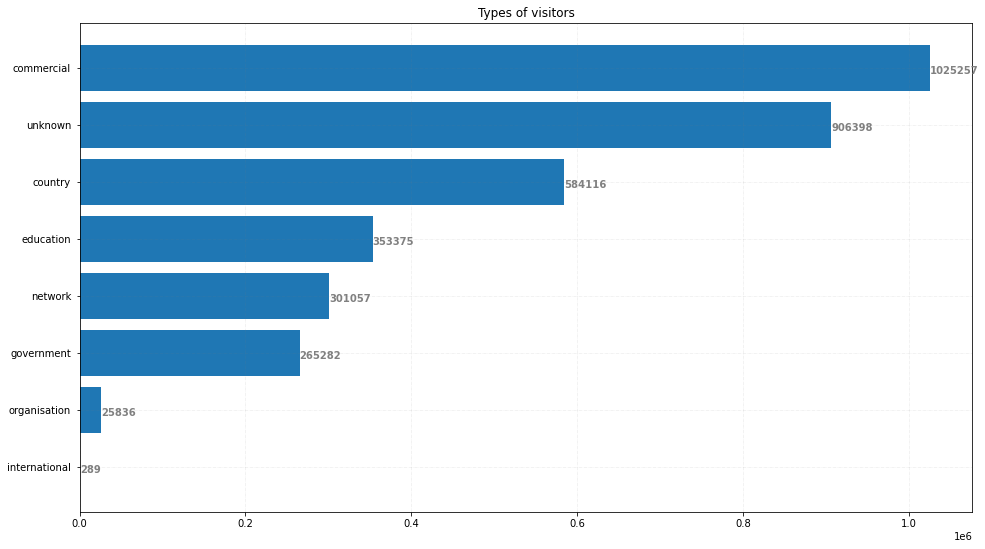

In [11]:
# group by and count number of visits
df_top_visitors = df_visitors.groupby(['category'])['category'].count().sort_values(ascending=False).reset_index(name='count')

# horizontal bar plot
fig, ax = plt.subplots(figsize =(16, 9))
ax.barh(df_top_visitors['category'], df_top_visitors['count'])
# add padding for better visibility
ax.xaxis.set_tick_params(pad = 3)
ax.yaxis.set_tick_params(pad = 5)
# Add x, y gridlines
ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)
# sort descending order
ax.invert_yaxis()
# Add annotation to bars
for i in ax.patches:   
    plt.text(i.get_width()+0.2, i.get_y()+0.5, 
             str(round((i.get_width()), 2)),
             fontsize = 10, fontweight ='bold',
             color ='grey') 
# Add Plot Title
ax.set_title('Types of visitors') 
plt.show()


Visiting countries (represents only a SUBSET based on identifiable country top-level domain):
1. Canada
2. UK
3. Japan
4. Australia
5. Germany


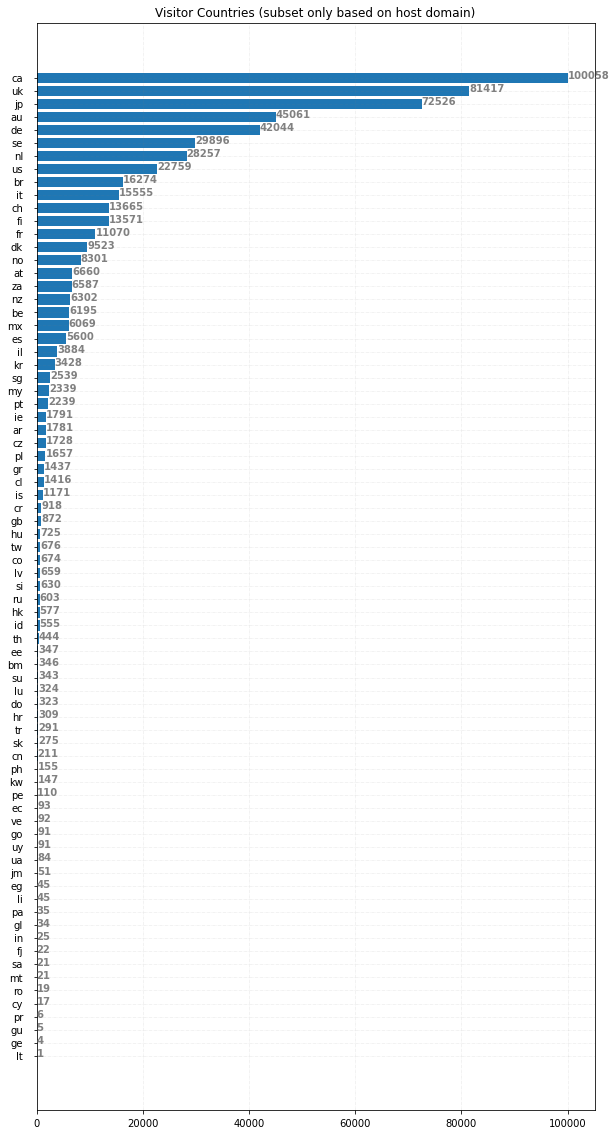

In [12]:
df_visitor_country = df_visitors.loc[df_visitors['category'] == 'country']
df_visitor_country = df_visitor_country.filter(['domain'])
df_visitor_country = df_visitor_country.groupby(['domain'])['domain'].count().sort_values(ascending=False).reset_index(name='count')
df_visitor_country.head()

# horizontal bar plot
fig, ax = plt.subplots(figsize =(10, 20))
ax.barh(df_visitor_country['domain'], df_visitor_country['count'])
# add padding for better visibility
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)
# Add x, y gridlines
ax.grid(visible= True, color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)
# sort descending order
ax.invert_yaxis()
# Add annotation to bars
for i in ax.patches:   
    plt.text(i.get_width()+0.2, i.get_y()+0.5, 
             str(round((i.get_width()), 2)),
             fontsize = 10, fontweight ='bold',
             color ='grey') 
# Add Plot Title
ax.set_title('Visitor Countries (subset only based on host domain)') 
plt.show()

In [13]:
# Dataframe resulting from host analysis
df_visitors

,index,host,domain,category
0,0,199.72.81.55,None,unknown
1,1,unicomp6.unicomp.net,net,network
2,2,199.120.110.21,None,unknown
3,3,burger.letters.com,com,commercial
4,4,199.120.110.21,None,unknown
...,...,...,...,...
3461605,3461605,gatekeeper.uccu.com,com,commercial
3461606,3461606,gatekeeper.uccu.com,com,commercial
3461607,3461607,cys-cap-9.wyoming.com,com,commercial
3461608,3461608,www-c8.proxy.aol.com,com,commercial


### 1.2 Timestamp
* Add Month column
* Add Day column
* Add Hour column
* Add Mins column
* Nominal category: AM or PM
* Nominal category: day of the week
* Insight idea: show trends based on:
    * busiest day of all time (within 2 months of 1995)
    * most visited day in a week
    * busiest hour in a day (can help inform the right time for website updates)

In [14]:
# create a new df for breaking down timestamp
df_timestamp = df_cleaned_logs[['index', 'timestamp']].copy()

df_timestamp['date'] = df_timestamp['timestamp'].dt.date

# extract month, date, hour, minutes, day of week
df_timestamp['month'] = df_timestamp['timestamp'].dt.month
df_timestamp['day'] = df_timestamp['timestamp'].dt.day
df_timestamp['hour'] = df_timestamp['timestamp'].dt.hour
df_timestamp['minutes'] = df_timestamp['timestamp'].dt.minute
df_timestamp['dayofweek'] = df_timestamp['timestamp'].dt.day_of_week

# Get a map to translate month
m = dict(zip(range(12),list(calendar.month_name)))
df_timestamp['month'] = df_timestamp['month'].map(m)

# Get a map to translate to day of week
d = dict(zip(range(7),list(calendar.day_name)))
df_timestamp['dayofweek'] = df_timestamp['dayofweek'].map(d)

# AM/PM category
df_timestamp['dayperiod'] = df_timestamp['hour'].apply(lambda x: 'AM' if x < 12 else 'PM')

# output of this will validate it looks right
df_timestamp.nunique(axis=0)

index        3461610
timestamp    2075518
date              58
month              2
day               31
hour              24
minutes           60
dayofweek          7
dayperiod          2
dtype: int64

#### Trend Analysis

The busiest days across the 2 month data set -- **TODO: try to see and explain what happened on those days**

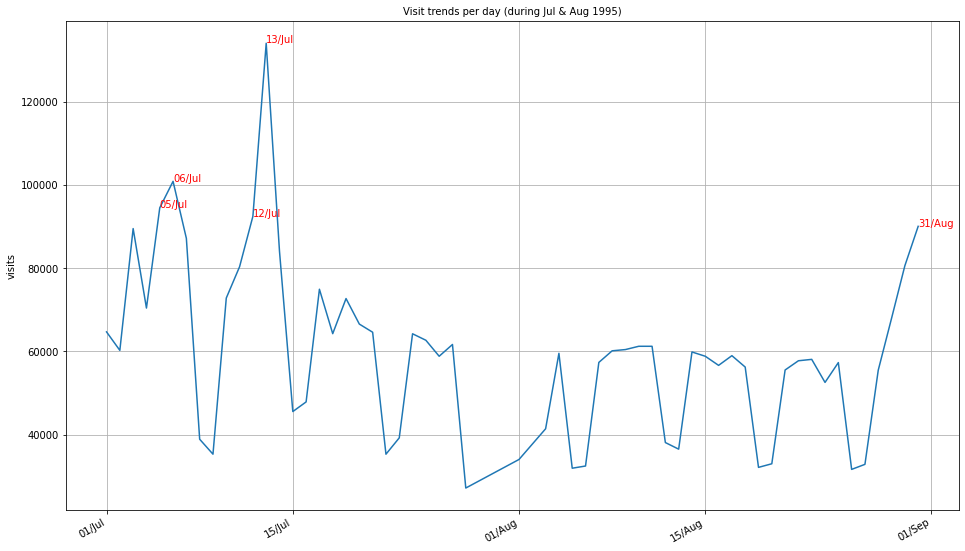

In [15]:
df_timestamp_days = df_timestamp.groupby(['date'])['date'].count().reset_index(name='visits')

# plot line chart
fig, ax = plt.subplots(figsize =(16, 9))
ax.plot(df_timestamp_days['date'], df_timestamp_days['visits'])

# Major ticks every half-month
ax.xaxis.set_major_locator(mdates.DayLocator(bymonthday=(1, 15)))
ax.grid(True)
ax.set_ylabel('visits')
ax.set_title('Visit trends per day (during Jul & Aug 1995)', fontsize='medium')
# Text in the x-axis.
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%b'))
# Rotates and right-aligns the x labels so they don't crowd each other.
for label in ax.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')

#annotate pertinent dates in data with visits greater than 90k
annotated_data = df_timestamp_days[df_timestamp_days['visits'] > 90000]
# Annotate data points
for index, row in annotated_data.iterrows():
    ax.annotate(row['date'].strftime('%d/%b'), 
                xy=(row['date'], row['visits']), color='red')

plt.show()

Days of the week access trends
* Thursdays are the busiest on both months -- **TODO: try to analyse on the type of requests**
* Weekends are relatively quieter than the weekdays

Text(0.5, 1.0, 'Day of week visit trends (during Jul & Aug 1995)')

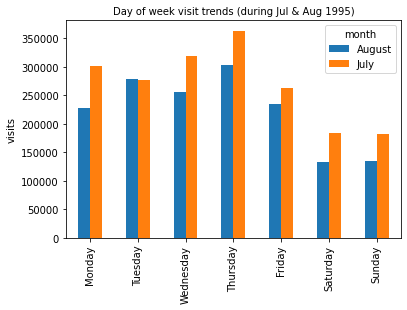

In [16]:
df_timestamp_days = df_timestamp.groupby(['dayofweek', 'month'])['dayofweek'].count().reset_index(name='visits')

day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
ax = pd.pivot_table(df_timestamp_days.reset_index(),
               index='dayofweek', columns='month', values='visits'
              ).loc[day_order].plot(kind='bar')

ax.set_ylabel('visits')
ax.set_xlabel('')
ax.set_title('Day of week visit trends (during Jul & Aug 1995)', fontsize='medium')

Hours in a day access trends
* Follows standard business hours activity (between 8am - 6pm)
* Busiest late after lunch
* Least activity on wee hours of the morning (4 - 6am) -- best time to do any patches
    * however, worthwhile to do further digging on the sites frequently visited during these timeframe to aid update rollouts.

Text(0.5, 1.0, 'Hour of day visit trends (during Jul & Aug 1995)')

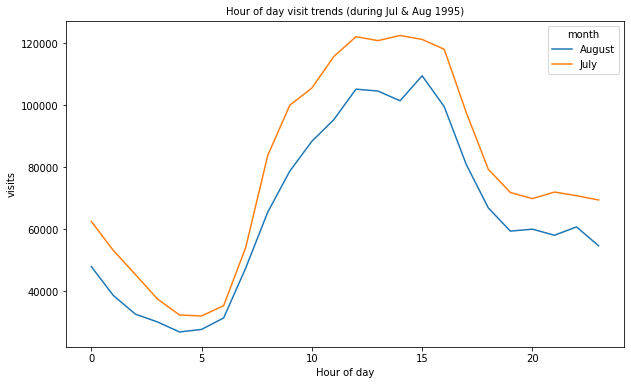

In [17]:
df_timestamp_days = df_timestamp.groupby(['hour', 'month'])['hour'].count().reset_index(name='visits')

ax = pd.pivot_table(df_timestamp_days.reset_index(),
               index='hour', columns='month', values='visits'
              ).plot(kind='line')

ax.figure.set_size_inches(10, 6)
ax.set_ylabel('visits')
ax.set_xlabel('Hour of day')
ax.set_title('Hour of day visit trends (during Jul & Aug 1995)', fontsize='medium')

In [18]:
# Dataframe resulting from timestamp analysis
df_timestamp

,index,timestamp,date,month,day,hour,minutes,dayofweek,dayperiod
0,0,1995-07-01 00:00:01,1995-07-01,July,1.0,0.0,0.0,Saturday,AM
1,1,1995-07-01 00:00:06,1995-07-01,July,1.0,0.0,0.0,Saturday,AM
2,2,1995-07-01 00:00:09,1995-07-01,July,1.0,0.0,0.0,Saturday,AM
3,3,1995-07-01 00:00:11,1995-07-01,July,1.0,0.0,0.0,Saturday,AM
4,4,1995-07-01 00:00:11,1995-07-01,July,1.0,0.0,0.0,Saturday,AM
...,...,...,...,...,...,...,...,...,...
3461605,3461605,1995-08-31 23:59:49,1995-08-31,August,31.0,23.0,59.0,Thursday,PM
3461606,3461606,1995-08-31 23:59:49,1995-08-31,August,31.0,23.0,59.0,Thursday,PM
3461607,3461607,1995-08-31 23:59:52,1995-08-31,August,31.0,23.0,59.0,Thursday,PM
3461608,3461608,1995-08-31 23:59:52,1995-08-31,August,31.0,23.0,59.0,Thursday,PM


### 1.3 Request
* Request method
* URL traversal path
* Page OR Resource OR None
* HTTP/1.0 is irrelevant (doesn't give insight because all requests use it for this dataset)

In [19]:
df_cleaned_logs['request'].head()

0                        GET /history/apollo/ HTTP/1.0
1                     GET /shuttle/countdown/ HTTP/1.0
2    GET /shuttle/missions/sts-73/mission-sts-73.ht...
3         GET /shuttle/countdown/liftoff.html HTTP/1.0
4    GET /shuttle/missions/sts-73/sts-73-patch-smal...
Name: request, dtype: object

In [20]:
def parse_method(req):
    try:
        method = req.split(' ')[0]
    except:
        method = None
    return method

def parse_url(req):
    try:
        url = req.split(' ')[1]
    except:
        url = None
    return url

# create a new df for breaking down request
df_request = df_cleaned_logs[['index', 'request']].copy()

df_request['reqmethod'] = df_request['request'].apply(parse_method).map(lambda x: str(x))
df_request['requrl'] = df_request['request'].apply(parse_url).map(lambda x: str(x))

# output of this will validate it looks right
df_request.nunique(axis=0)

index        3461610
request        32845
reqmethod         12
requrl         31053
dtype: int64

Clean Request Method values (initial list includes 12 items, 9 of which unreadable with invalid characters)
-- will be using an UNKNOWN category to replace these invalid

List of allowable HTTP Methods: https://http.dev/methods

Certain request URLs that are readable but have no req method (all are tied with 400 response):
* '1/history/apollo/images/'
* 'huttle/countdown/
* '?'

In [21]:
HTTP_Methods = ['GET', 'POST', 'PUT', 'PATCH', 'DELETE', 'HEAD', 'OPTIONS', 'TRACE', 'CONNECT']

df_request['reqmethod'] = df_request['reqmethod'].apply(lambda x: x if x in HTTP_Methods else 'UNKNOWN')

df_request['reqmethod'].unique()

array(['GET', 'HEAD', 'POST', 'UNKNOWN'], dtype=object)

Break down url path to nominal categories:
* Directory
* Resource
* Resource Type: Directory | Page | File | Image | AV | Unknown

In [22]:
def get_directory(url):
    try:
        url = url.replace('HTTP/1.0', '').strip()
        last_slash = url.rindex('/')
        directory = url[:last_slash + 1]    #to include the rear slash
    except:
        directory = url #pd.NA
    return directory

df_request['reqdirectory'] = df_request['requrl'].apply(lambda x: get_directory(str(x)))

df_request['reqdirectory'].nunique()

2118

In [23]:
def get_resource(url):
    try:
        url = url.replace('HTTP/1.0', '').strip()
        last_slash = url.rindex('/')
        if last_slash < len(url):
            resource = url[(last_slash + 1):]
        else:
            resource = ''
    except:
        resource = pd.NA
    return resource

df_request['reqresource'] = df_request['requrl'].apply(get_resource).map(lambda x: str(x))

df_request['reqresource'].nunique()

28421

In [24]:
IMAGE_TYPES = ['gif', 'jpg', 'jpeg', 'tiff', 'png', 'bmp', 'xbm', 'eps', 'art', 'ps']
AV_TYPES = ['wav', 'avi', 'mp3', 'wma', 'mpg', 'ksc']
FILE_TYPES = ['doc', 'rtf', 'xls', 'txt', 'bak', 'xb', 'pdf', 'sta', 'bps', 'new', 'zip', 'bad', 'out', 'orig','dat', 'lists']
PAGE_TYPES = ['html', 'pl', 'htm', 'map', 'perl', 'dec', 'software']

def get_resource_type(resource):
    try:
        dot_index = resource.rindex('.')
        file_type = resource[(dot_index + 1):].lower()
        if file_type in IMAGE_TYPES:
            restype = 'Image'
        elif file_type in PAGE_TYPES or file_type.startswith('pl'):
            restype = 'Page'
        elif file_type in AV_TYPES:
            restype = 'AV'
        elif file_type in FILE_TYPES:
            restype = 'File'
        else:
            restype = 'UNKNOWN'
    except:
        restype = 'Directory'
    return restype

df_request['reqrestype'] = df_request['reqresource'].apply(get_resource_type).map(lambda x: str(x))

df_request['reqrestype'].unique()

array(['Directory', 'Page', 'Image', 'AV', 'File', 'UNKNOWN'],
      dtype=object)

Identify top 20 non-image resources frequently accessed.

Note: image resources are 'website furniture' and doesn't give any useful information by including it in identifying top 10 most accessed resources

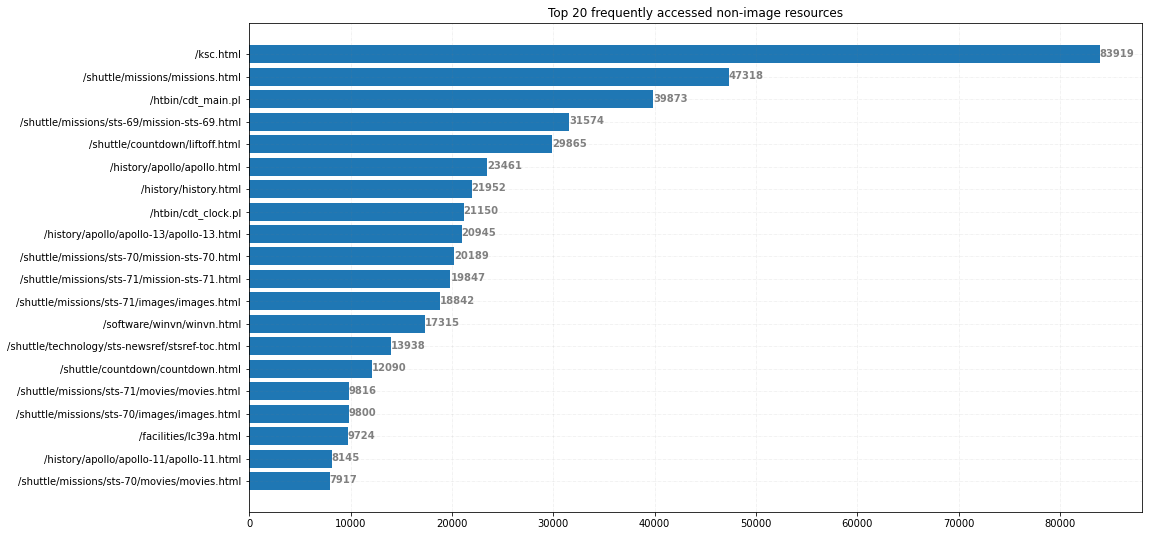

In [25]:
# group by and count number of visits
df_top_request_resource = df_request[(df_request['reqrestype'] != 'Image') & (df_request['reqrestype'] != 'Directory')]
df_top_request_resource = df_top_request_resource.groupby(['requrl'])['requrl'].count().sort_values(ascending=False).reset_index(name='count')
df_top_request_resource = df_top_request_resource.head(20)

# horizontal bar plot
fig, ax = plt.subplots(figsize =(16, 9))
ax.barh(df_top_request_resource['requrl'], df_top_request_resource['count'])
# add padding for better visibility
ax.xaxis.set_tick_params(pad = 3)
ax.yaxis.set_tick_params(pad = 5)
# Add x, y gridlines
ax.grid(visible = True, color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)
# sort descending order
ax.invert_yaxis()
# Add annotation to bars
for i in ax.patches:   
    plt.text(i.get_width()+0.2, i.get_y()+0.5, 
             str(round((i.get_width()), 2)),
             fontsize = 10, fontweight ='bold',
             color ='grey') 
# Add Plot Title
ax.set_title('Top 20 frequently accessed non-image resources') 
plt.show()


Identify top 20 directories frequently visited (i.e. requests made without specifying the end/leaf resource)

As expected, the root site '/' should have the highest hit count.

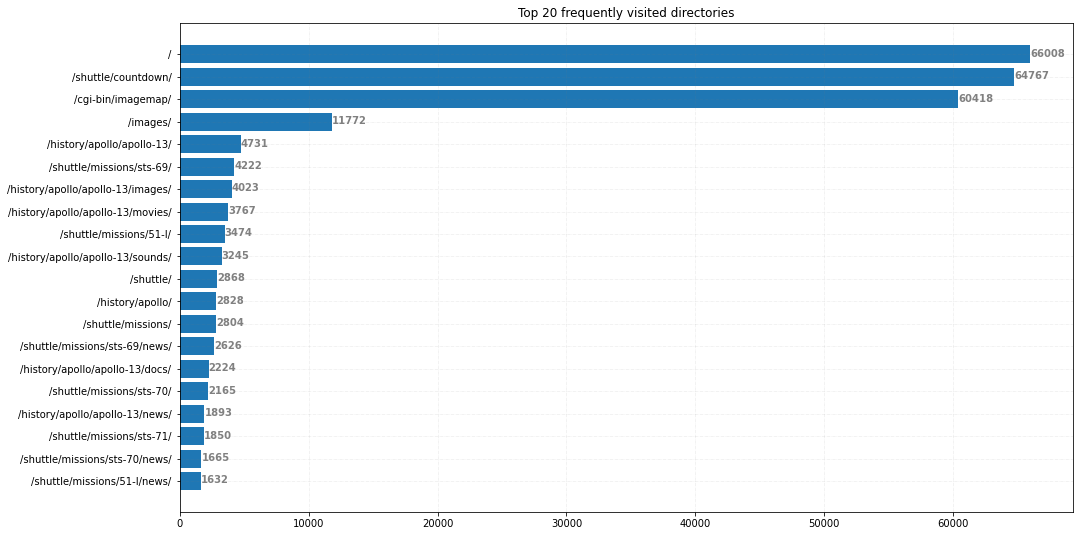

In [26]:
# group by and count number of visits
df_top_request_directory = df_request[df_request['reqrestype'] == 'Directory']
df_top_request_directory = df_top_request_directory.groupby(['reqdirectory'])['reqdirectory'].count().sort_values(ascending=False).reset_index(name='count')
df_top_request_directory = df_top_request_directory.head(20)

# horizontal bar plot
fig, ax = plt.subplots(figsize =(16, 9))
ax.barh(df_top_request_directory['reqdirectory'], df_top_request_directory['count'])
# add padding for better visibility
ax.xaxis.set_tick_params(pad = 3)
ax.yaxis.set_tick_params(pad = 5)
# Add x, y gridlines
ax.grid(visible = True, color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)
# sort descending order
ax.invert_yaxis()
# Add annotation to bars
for i in ax.patches:   
    plt.text(i.get_width()+0.2, i.get_y()+0.5, 
             str(round((i.get_width()), 2)),
             fontsize = 10, fontweight ='bold',
             color ='grey') 
# Add Plot Title
ax.set_title('Top 20 frequently visited directories') 
plt.show()


Overview of the anomalies detected and can potentially be cleaned or re-categorised for observation.

In [27]:
df_request_unknown = df_request[df_request['reqrestype'] == 'UNKNOWN']

df_request_unknown['requrl'].to_csv('./request_url_anomalies.csv', sep='\t', encoding='utf-8')

df_request_unknown.nunique()

index           2393
request          899
reqmethod          2
requrl           880
reqdirectory     146
reqresource      823
reqrestype         1
dtype: int64

In [28]:
# Dataframe resulting from request analysis
df_request

,index,request,reqmethod,requrl,reqdirectory,reqresource,reqrestype
0,0,GET /history/apollo/ HTTP/1.0,GET,/history/apollo/,/history/apollo/,,Directory
1,1,GET /shuttle/countdown/ HTTP/1.0,GET,/shuttle/countdown/,/shuttle/countdown/,,Directory
2,2,GET /shuttle/missions/sts-73/mission-sts-73.ht...,GET,/shuttle/missions/sts-73/mission-sts-73.html,/shuttle/missions/sts-73/,mission-sts-73.html,Page
3,3,GET /shuttle/countdown/liftoff.html HTTP/1.0,GET,/shuttle/countdown/liftoff.html,/shuttle/countdown/,liftoff.html,Page
4,4,GET /shuttle/missions/sts-73/sts-73-patch-smal...,GET,/shuttle/missions/sts-73/sts-73-patch-small.gif,/shuttle/missions/sts-73/,sts-73-patch-small.gif,Image
...,...,...,...,...,...,...,...
3461605,3461605,GET /images/ksclogosmall.gif HTTP/1.0,GET,/images/ksclogosmall.gif,/images/,ksclogosmall.gif,Image
3461606,3461606,GET /images/lc39a-logo.gif HTTP/1.0,GET,/images/lc39a-logo.gif,/images/,lc39a-logo.gif,Image
3461607,3461607,GET /shuttle/missions/sts-71/movies/sts-71-lau...,GET,/shuttle/missions/sts-71/movies/sts-71-launch-...,/shuttle/missions/sts-71/movies/,sts-71-launch-3.mpg,AV
3461608,3461608,GET /icons/unknown.xbm HTTP/1.0,GET,/icons/unknown.xbm,/icons/,unknown.xbm,Image


### 1.4 Response
* nominal refer to https://en.wikipedia.org/wiki/List_of_HTTP_status_codes
    * 1xx: informational
    * 2xx: success
    * 3xx: redirect
    * 4xx: client error
    * 5xx: server error
* more indicator may be needed to identify points for improvement. 

In [29]:
df_response = df_cleaned_logs[['index', 'response']].copy()

df_response['response'] = pd.to_numeric(df_response['response'], errors='coerce', downcast='integer')

df_response['response'] = df_response['response'].fillna(400).apply(np.int64)

df_response['response'].unique()


array([200, 304, 302, 404, 403, 400, 500, 501])

Log entries that have anomalous parsed http response are defaulted to 404 NOT FOUND. Justification - it reflects the user's likely experience that they were not able to retrieve the page they're looking for.

Status codes 1, 2 and 3 are deemed to be successful, the rest are deemed as failure. 
* **TODO** Thought experiment for later improvement: for Status code 3 as fail - redirection introduces latency that could have an impact to user experience.

In [30]:
def get_response_status(code):
    try:
        respstatus = HTTPStatus(code).phrase
    except:
        respstatus = HTTPStatus(404).phrase #None
    return respstatus

def get_response_class(code):
    switcher = {
        1: 'informational',
        2: 'successful',
        3: 'redirection',
        4: 'client error',
        5: 'server error',
    }
    code_index = int(str(code)[0])
    respclass = switcher.get(code_index)
    return respclass

def get_response_result(code):
    code_index = int(str(code)[0])
    if code_index in [1, 2, 3]:
        result = 'success'
    else:
        result = 'fail'
    return result

In [31]:
df_response['respstatus'] = df_response['response'].apply(get_response_status)
df_response['respstatus'].unique()

array(['OK', 'Not Modified', 'Found', 'Not Found', 'Forbidden',
       'Bad Request', 'Internal Server Error', 'Not Implemented'],
      dtype=object)

In [32]:
df_response['respclass'] = df_response['response'].apply(get_response_class)
df_response['respclass'].unique()

array(['successful', 'redirection', 'client error', 'server error'],
      dtype=object)

In [33]:
df_response['result'] = df_response['response'].apply(get_response_result)
df_response['result'].unique()

array(['success', 'fail'], dtype=object)

Distribution of response codes across 2 month timeframe.

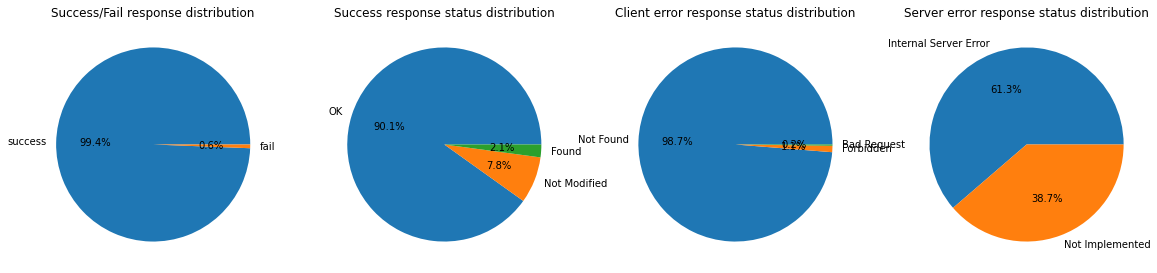

In [34]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=4,figsize=(20,20))

# group by and count number of visits
df_top_responses = df_response.groupby(['result'])['result'].count().sort_values(ascending=False).reset_index(name='count')

# horizontal bar plot
labels = df_top_responses['result']
values = df_top_responses['count'] / len(df_top_responses)
ax1.pie(values, labels = labels, autopct = '%1.1f%%')
ax1.set_title('Success/Fail response distribution')

df_success_responses = df_response.loc[df_response['result'] == 'success']

# group by and count number of visits
df_success_responses = df_success_responses.groupby(['respstatus'])['respstatus'].count().sort_values(ascending=False).reset_index(name='count')

labels = df_success_responses['respstatus']
values = df_success_responses['count'] / len(df_success_responses)
ax2.pie(values,labels = labels, autopct = '%1.1f%%')
ax2.set_title('Success response status distribution')

df_fail_responses = df_response.loc[df_response['respclass'] == 'client error']

# group by and count number of visits
df_fail_responses = df_fail_responses.groupby(['respstatus'])['respstatus'].count().sort_values(ascending=False).reset_index(name='count')

labels = df_fail_responses['respstatus']
values = df_fail_responses['count'] / len(df_fail_responses)
ax3.pie(values, labels = labels, autopct = '%1.1f%%')
ax3.set_title('Client error response status distribution')

df_fail_responses = df_response.loc[df_response['respclass'] == 'server error']

# group by and count number of visits
df_fail_responses = df_fail_responses.groupby(['respstatus'])['respstatus'].count().sort_values(ascending=False).reset_index(name='count')

labels = df_fail_responses['respstatus']
values = df_fail_responses['count'] / len(df_fail_responses)
ax4.pie(values,labels = labels, autopct = '%1.1f%%')
ax4.set_title('Server error response status distribution')

plt.show()

In [35]:
# Dataframe resulting from response analysis
df_response

,index,response,respstatus,respclass,result
0,0,200,OK,successful,success
1,1,200,OK,successful,success
2,2,200,OK,successful,success
3,3,304,Not Modified,redirection,success
4,4,200,OK,successful,success
...,...,...,...,...,...
3461605,3461605,304,Not Modified,redirection,success
3461606,3461606,304,Not Modified,redirection,success
3461607,3461607,200,OK,successful,success
3461608,3461608,200,OK,successful,success


### 1.5 Bytes
* Clean values in bytes variable
* Threshold indicator to build case for potential point for improvement - at this point, I'm unsure if basic  statistical distribution analysis is strong enough to make this threshold inference.

Null values are replaced with 0 as it is likely that no content was returned on the 

Small percentage of 0 content reponse - 10%

In [36]:
df_bytes = df_cleaned_logs[['index', 'bytes']].copy()

df_bytes['bytes'] = pd.to_numeric(df_bytes['bytes'], errors='coerce', downcast='integer')

df_bytes['bytes'] = df_bytes['bytes'].fillna(0)

print('percentage of 0 content response: ', str(df_bytes[df_bytes['bytes'] == 0].count() / df_bytes.shape[0]))

percentage of 0 content response:  index    0.090681
bytes    0.090681
dtype: float64


There is a wide range of returned bytes from 28 bytes to 6MB. Standard deviation is 76KB.

In [37]:
df_bytes[df_bytes['bytes'] > 0].describe()

,index,bytes
count,3.147708e+06,3.147708e+06
mean,1.719330e+06,2.081652e+04
std,9.971918e+05,7.632950e+04
min,0.000000e+00,2.800000e+01
25%,8.531548e+05,1.037000e+03
50%,1.719024e+06,4.142000e+03
75%,2.579906e+06,1.185300e+04
max,3.461609e+06,6.823936e+06


For readability, the unit standard is changed from bytes to KB: Standard deviation, 25th and 50th percentile are on KB range.

In [38]:
df_bytes['bytes'] = df_bytes['bytes'] / 1000

By using box plot to understand distribution, it became evident that there are a lot of identified outliers and that most of the content density is in less than 1KB range.

There is a need to understand the distribution further and to potentially categorize the response content (e.g. S, M, L), which could potentially help with optimisation (e.g. CDN)

Also, it is notable from the graph that there is a single outlier at the 6MB mark that have influenced the disparity between the initial quantiles and box plot. However, it is not prudent to remove this outlier at the moment, given that it may still be a valid content.

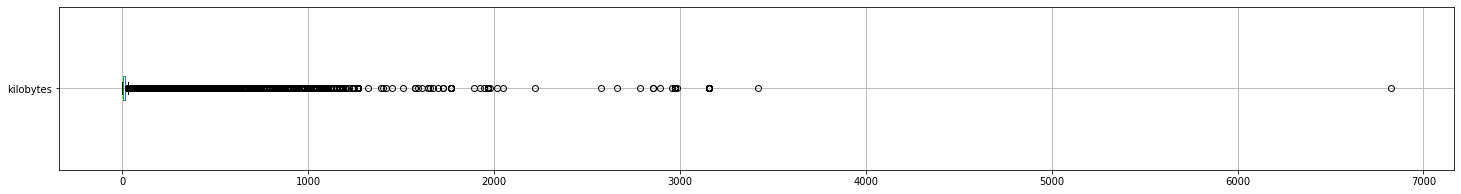

In [39]:
df_return_bytes = df_bytes[df_bytes['bytes'] > 0]
fig, ax = plt.subplots(figsize=(25,3))
ax = df_return_bytes.boxplot(column='bytes', vert=False)
ax.set_yticklabels(['kilobytes'])
plt.show()

Zooming in to the non-outlier fences that the box plot hand indicated to get a clearer view of what is defined as 'normal' with respect to data. NOTE: this is not implying normal distribution.

It is also interesting to note that majority of the 'normal' requests is under 1KB (mode = 0.7KB).

The mode and median are a better indicator of the 'normal' requests that can be expected, instead of the mean.

iqr:  10.815999999999999  low fence:  -15.186999999999998  high fence:  28.076999999999998
mean:  20.8165176666672
median:  4.142
mode: 0.786


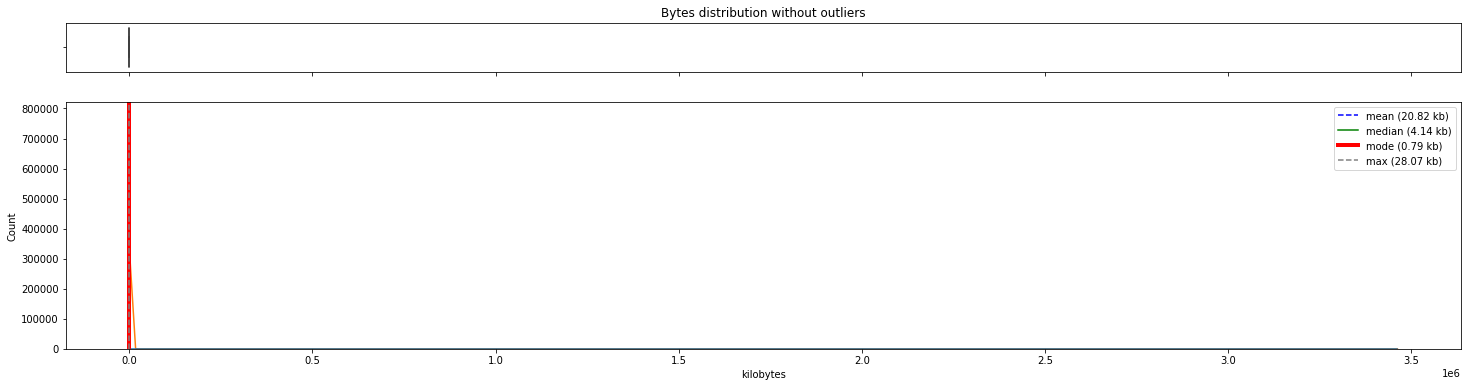

In [40]:
df_25pct_return_bytes = df_return_bytes.quantile(0.25)['bytes']
df_50pct_return_bytes = df_return_bytes.quantile(0.5)['bytes']
df_75pct_return_bytes = df_return_bytes.quantile(0.75)['bytes']

#df_1stqt_return_bytes = df_return_bytes[df_return_bytes['bytes'].le(df_25pct_return_bytes)].filter(['bytes'])
#df_2ndqt_return_bytes = df_return_bytes[df_return_bytes['bytes'].gt(df_25pct_return_bytes) & df_return_bytes['bytes'].le(df_50pct_return_bytes)].filter(['bytes'])
#df_3rdqt_return_bytes = df_return_bytes[df_return_bytes['bytes'].gt(df_50pct_return_bytes) & df_return_bytes['bytes'].le(df_75pct_return_bytes)].filter(['bytes'])

iqr = df_75pct_return_bytes - df_25pct_return_bytes #Interquartile range
fence_low = df_25pct_return_bytes - (1.5*iqr)
fence_high = df_75pct_return_bytes + (1.5*iqr)

print('iqr: ', iqr, ' low fence: ', fence_low, ' high fence: ', fence_high)
bytes_mean = df_return_bytes.mean()['bytes']
print('mean: ', bytes_mean)
bytes_median = df_return_bytes.median()['bytes']
print('median: ', bytes_median)
bytes_mode = df_return_bytes.mode()['bytes'][0]
print('mode:',  bytes_mode)

fig, (ax_box, ax_hist) = plt.subplots(2, sharex=True, figsize=(25,6), gridspec_kw= {"height_ratios": (0.2, 1)})

sns.boxplot(data=df_return_bytes, x="bytes", ax=ax_box, showfliers=False)
sns.histplot(df_return_bytes[df_return_bytes['bytes'] < fence_high], bins=np.arange(0, fence_high, 1), kde=True)

ax_box.set_title('Bytes distribution without outliers')
ax_box.set(xlabel='')
ax_hist.set(xlabel='kilobytes')
ax_hist.axvline(bytes_mean, color='b', linestyle='--', label='mean (%.2f kb)' % bytes_mean)
ax_hist.axvline(bytes_median, color='g', linestyle='-', label='median (%.2f kb)' % bytes_median)
ax_hist.axvline(bytes_mode, color='r', linestyle='-', linewidth=4, label='mode (%.2f kb)' % bytes_mode)
max_normal = df_return_bytes[df_return_bytes['bytes'] < fence_high].max()['bytes']
ax_hist.axvline(max_normal, color='gray', linestyle='--', label='max (%.2f kb)' % max_normal)

plt.legend()
plt.show()

What about the perceived outliers? We are not going to remove them, just observe them.

outliers mean:  111.47845353253273
outliers median:  57.344
outliers mode: 46.053


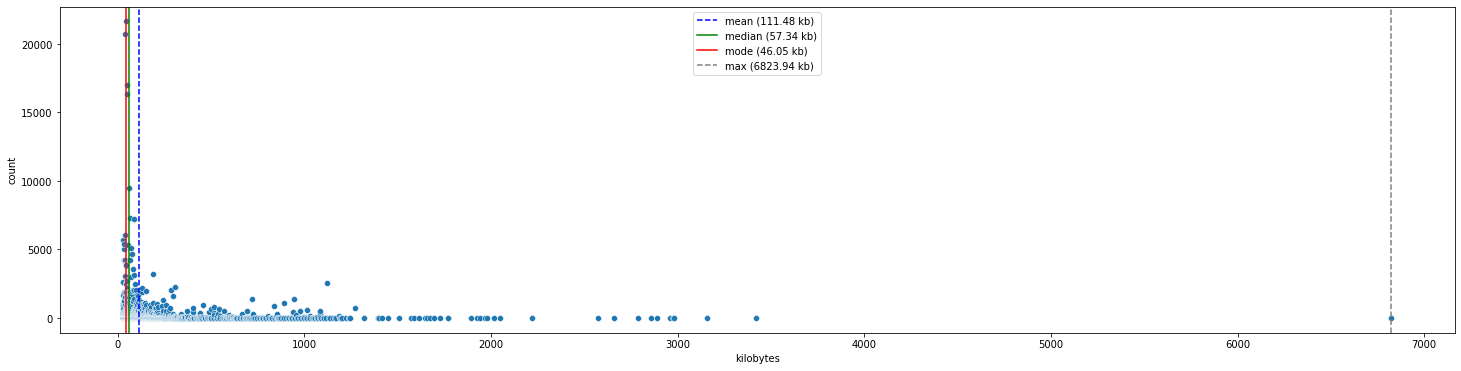

In [41]:
df_outliers = df_return_bytes[df_return_bytes['bytes'] > fence_high]

outliers_fence_low = df_outliers.min()['bytes'] 
outliers_fence_high = df_outliers.max()['bytes']

obytes_mean = df_outliers.mean()['bytes']
print('outliers mean: ', obytes_mean)
obytes_median = df_outliers.median()['bytes']
print('outliers median: ', obytes_median)
obytes_mode = df_outliers.mode()['bytes'][0]
print('outliers mode:',  obytes_mode)

fig, oax_hist = plt.subplots(figsize=(25,6))

df_outliers = df_outliers.groupby(['bytes'])['bytes'].count().reset_index(name='count')
oax_hist = sns.scatterplot(x='bytes', y='count', data=df_outliers)

oax_hist.set(xlabel='kilobytes')
oax_hist.axvline(obytes_mean, color='b', linestyle='--', label='mean (%.2f kb)' % obytes_mean)
oax_hist.axvline(obytes_median, color='g', linestyle='-', label='median (%.2f kb)' % obytes_median)
oax_hist.axvline(obytes_mode, color='r', linestyle='-', label='mode (%.2f kb)' % obytes_mode)
oax_hist.axvline(outliers_fence_high, color='gray', linestyle='--', label='max (%.2f kb)' % outliers_fence_high)

plt.legend()
plt.show()

We will now categorise bytes according to basic statistical distribution analysis, where the threshold of what's considered 'normal' and 'for observation'


In [42]:
df_bytes['bytesaction'] = df_bytes['bytes'].apply(lambda x: 'normal' if x <= fence_high else 'for observation')

In [43]:
# Dataframe resulting from bytes analysis
df_bytes

,index,bytes,bytesaction
0,0,6.245,normal
1,1,3.985,normal
2,2,4.085,normal
3,3,0.000,normal
4,4,4.179,normal
...,...,...,...
3461605,3461605,0.000,normal
3461606,3461606,0.000,normal
3461607,3461607,57.344,for observation
3461608,3461608,0.515,normal


## 3. Identify relationship between features

Merge analysis dataframes:
* df_visitors
* df_timestamp
* df_request
* df_response
* df_bytes

In [44]:
#df_combined = pd.merge(df_visitors, df_timestamp, on='index')
#df_combined = pd.merge(df_combined, df_request, on='index')
#df_combined = pd.merge(df_combined, df_response, on='index')
#df_combined = pd.merge(df_combined, df_bytes, on='index')

df_combined = df_visitors.merge(df_timestamp, on='index').merge(df_request, on='index').merge(df_response, on='index').merge(df_bytes, on='index')

df_combined

,index,host,domain,category,timestamp,date,month,day,hour,minutes,...,requrl,reqdirectory,reqresource,reqrestype,response,respstatus,respclass,result,bytes,bytesaction
0,0,199.72.81.55,None,unknown,1995-07-01 00:00:01,1995-07-01,July,1.0,0.0,0.0,...,/history/apollo/,/history/apollo/,,Directory,200,OK,successful,success,6.245,normal
1,1,unicomp6.unicomp.net,net,network,1995-07-01 00:00:06,1995-07-01,July,1.0,0.0,0.0,...,/shuttle/countdown/,/shuttle/countdown/,,Directory,200,OK,successful,success,3.985,normal
2,2,199.120.110.21,None,unknown,1995-07-01 00:00:09,1995-07-01,July,1.0,0.0,0.0,...,/shuttle/missions/sts-73/mission-sts-73.html,/shuttle/missions/sts-73/,mission-sts-73.html,Page,200,OK,successful,success,4.085,normal
3,3,burger.letters.com,com,commercial,1995-07-01 00:00:11,1995-07-01,July,1.0,0.0,0.0,...,/shuttle/countdown/liftoff.html,/shuttle/countdown/,liftoff.html,Page,304,Not Modified,redirection,success,0.000,normal
4,4,199.120.110.21,None,unknown,1995-07-01 00:00:11,1995-07-01,July,1.0,0.0,0.0,...,/shuttle/missions/sts-73/sts-73-patch-small.gif,/shuttle/missions/sts-73/,sts-73-patch-small.gif,Image,200,OK,successful,success,4.179,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3461605,3461605,gatekeeper.uccu.com,com,commercial,1995-08-31 23:59:49,1995-08-31,August,31.0,23.0,59.0,...,/images/ksclogosmall.gif,/images/,ksclogosmall.gif,Image,304,Not Modified,redirection,success,0.000,normal
3461606,3461606,gatekeeper.uccu.com,com,commercial,1995-08-31 23:59:49,1995-08-31,August,31.0,23.0,59.0,...,/images/lc39a-logo.gif,/images/,lc39a-logo.gif,Image,304,Not Modified,redirection,success,0.000,normal
3461607,3461607,cys-cap-9.wyoming.com,com,commercial,1995-08-31 23:59:52,1995-08-31,August,31.0,23.0,59.0,...,/shuttle/missions/sts-71/movies/sts-71-launch-...,/shuttle/missions/sts-71/movies/,sts-71-launch-3.mpg,AV,200,OK,successful,success,57.344,for observation
3461608,3461608,www-c8.proxy.aol.com,com,commercial,1995-08-31 23:59:52,1995-08-31,August,31.0,23.0,59.0,...,/icons/unknown.xbm,/icons/,unknown.xbm,Image,200,OK,successful,success,0.515,normal


## 4. Recommendations (?)

* **TODO** Provide recommended links per page: e.g. "Other people who visited this page, found this useful as well"
* **TODO** Provide recommendation on how to improve navigation:
    * Exploit the 404 patterns (must be able to link back through graph access of user navigation path)
    * Think of how we can augment this with GPT to improve experience.


Do PCA or GridSearch for dimensionality reduction